In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from skimage import feature, color, transform, io
import logging

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load image
img = cv2.imread('/content/drive/MyDrive/My Work/Traffic Data/img_afterKLT.png')

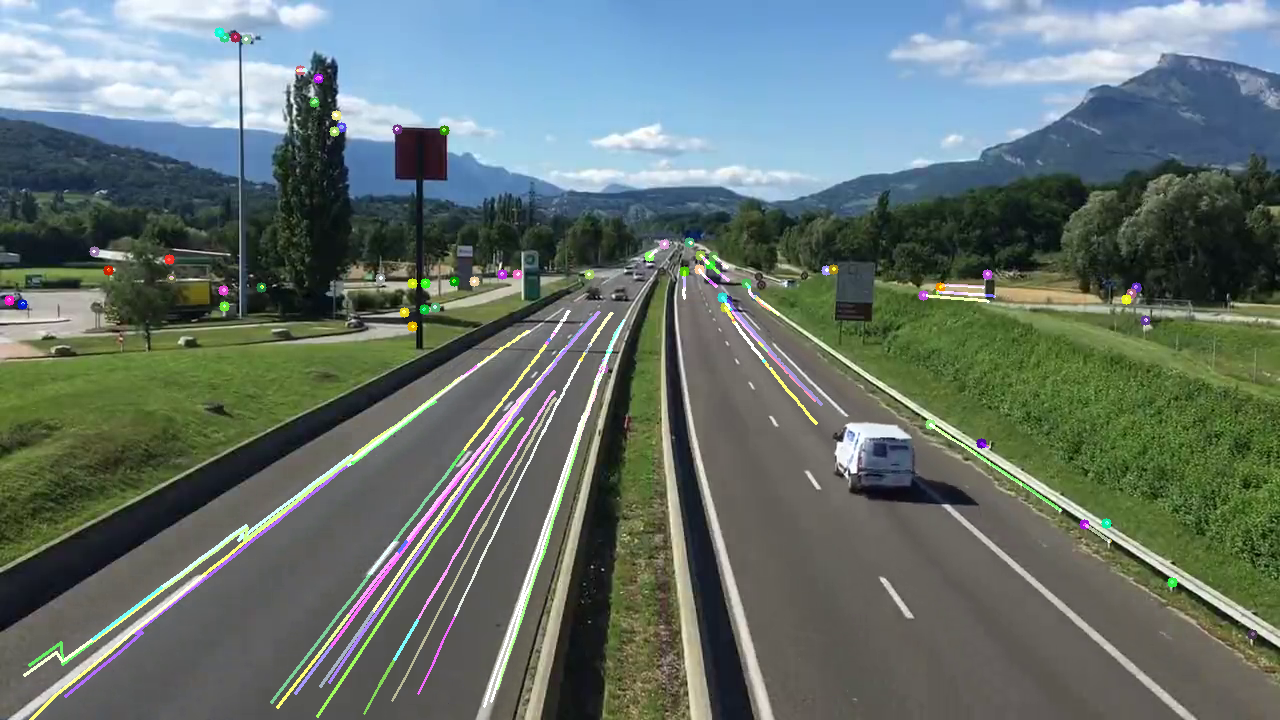

In [ ]:
cv2_imshow(img)

## Edgelet Detection:

In [ ]:
def compute_edgelets(image, sigma=3):
    """Create edgelets as in the paper.
    Uses canny edge detection and then finds (small) lines using probabilstic
    hough transform as edgelets.
    Parameters
    ----------
    image: ndarray
        Image for which edgelets are to be computed.
    sigma: float
        Smoothing to be used for canny edge detection.
    Returns
    -------
    locations: ndarray of shape (n_edgelets, 2)
        Locations of each of the edgelets.
    directions: ndarray of shape (n_edgelets, 2)
        Direction of the edge (tangent) at each of the edgelet.
    strengths: ndarray of shape (n_edgelets,)
        Length of the line segments detected for the edgelet.
    """
    gray_img = color.rgb2gray(image)
    edges = feature.canny(gray_img, sigma)
    lines = transform.probabilistic_hough_line(edges, line_length=3,
                                               line_gap=2)

    locations = []
    directions = []
    strengths = []

    for p0, p1 in lines:
        p0, p1 = np.array(p0), np.array(p1)
        locations.append((p0 + p1) / 2)
        directions.append(p1 - p0)
        strengths.append(np.linalg.norm(p1 - p0))

    # convert to numpy arrays and normalize
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)

    directions = np.array(directions) / \
        np.linalg.norm(directions, axis=1)[:, np.newaxis]

    return (locations, directions, strengths)

In [ ]:
# Compute edgelets
edgelets1 = compute_edgelets(img)

In [ ]:
def vis_edgelets(image, edgelets, show=True):
    """Helper function to visualize edgelets."""
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap = 'gray')
    locations, directions, strengths = edgelets
    for i in range(locations.shape[0]):
        xax = [locations[i, 0] - directions[i, 0] * strengths[i] / 2,
               locations[i, 0] + directions[i, 0] * strengths[i] / 2]
        yax = [locations[i, 1] - directions[i, 1] * strengths[i] / 2,
               locations[i, 1] + directions[i, 1] * strengths[i] / 2]

        plt.plot(xax, yax, 'r-')

    if show:
        plt.show()

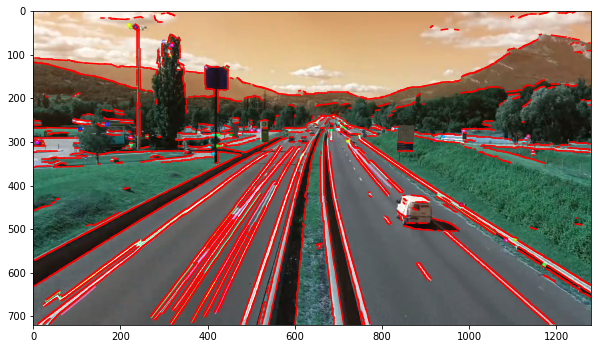

In [ ]:
# View edgelets
vis_edgelets(img, edgelets1)

## Dominant Vanishing Point (RANSAC):

In [ ]:
def edgelet_lines(edgelets):
    """Compute lines in homogenous system for edglets.
    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    Returns
    -------
    lines: ndarray of shape (n_edgelets, 3)
        Lines at each of edgelet locations in homogenous system.
    """
    locations, directions, _ = edgelets
    normals = np.zeros_like(directions)
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1)
    return lines

In [ ]:
def compute_votes(edgelets, model, threshold_inlier=5):
    """Compute votes for each of the edgelet against a given vanishing point.
    Votes for edgelets which lie inside threshold are same as their strengths,
    otherwise zero.
    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    model: ndarray of shape (3,)
        Vanishing point model in homogenous cordinate system.
    threshold_inlier: float
        Threshold to be used for computing inliers in degrees. Angle between
        edgelet direction and line connecting the  Vanishing point model and
        edgelet location is used to threshold.
    Returns
    -------
    votes: ndarry of shape (n_edgelets,)
        Votes towards vanishing point model for each of the edgelet.
    """
    vp = model[:2] / model[2]

    locations, directions, strengths = edgelets

    est_directions = locations - vp
    dot_prod = np.sum(est_directions * directions, axis=1)
    abs_prod = np.linalg.norm(directions, axis=1) * \
        np.linalg.norm(est_directions, axis=1)
    abs_prod[abs_prod == 0] = 1e-5

    cosine_theta = dot_prod / abs_prod
    theta = np.arccos(np.abs(cosine_theta))

    theta_thresh = threshold_inlier * np.pi / 180
    return (theta < theta_thresh) * strengths

In [ ]:
def ransac_vanishing_point(edgelets, num_ransac_iter=2000, threshold_inlier=5):
    """Estimate vanishing point using Ransac.
    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    num_ransac_iter: int
        Number of iterations to run ransac.
    threshold_inlier: float
        threshold to be used for computing inliers in degrees.
    Returns
    -------
    best_model: ndarry of shape (3,)
        Best model for vanishing point estimated.
    Reference
    ---------
    Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
    """
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 2]

    best_model = None
    best_votes = np.zeros(num_pts)

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]

        current_model = np.cross(l1, l2)

        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # reject degenerate candidates
            continue

        current_votes = compute_votes(
            edgelets, current_model, threshold_inlier)

        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes
            logging.info("Current best model has {} votes at iteration {}".format(
                current_votes.sum(), ransac_iter))

    return best_model

In [ ]:
vp1 = ransac_vanishing_point(edgelets1, num_ransac_iter=2000, threshold_inlier=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


In [ ]:
def reestimate_model(model, edgelets, threshold_reestimate=5):
    """Reestimate vanishing point using inliers and least squares.
    All the edgelets which are within a threshold are used to reestimate model
    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
        All edgelets from which inliers will be computed.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.
    Returns
    -------
    restimated_model: ndarry of shape (3,)
        Reestimated model for vanishing point in homogenous coordinates.
    """
    locations, directions, strengths = edgelets

    inliers = compute_votes(edgelets, model, threshold_reestimate) > 0
    locations = locations[inliers]
    directions = directions[inliers]
    strengths = strengths[inliers]

    lines = edgelet_lines((locations, directions, strengths))

    a = lines[:, :2]
    b = -lines[:, 2]
    est_model = np.linalg.lstsq(a, b)[0]
    return np.concatenate((est_model, [1.]))

In [ ]:
vp1 = reestimate_model(vp1, edgelets1, threshold_reestimate=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [ ]:
def vis_model(image, model, show=True):
    """Helper function to visualize computed model."""
    import matplotlib.pyplot as plt
    edgelets = compute_edgelets(image)
    locations, directions, strengths = edgelets
    inliers = compute_votes(edgelets, model, 10) > 0

    edgelets = (locations[inliers], directions[inliers], strengths[inliers])
    locations, directions, strengths = edgelets
    vis_edgelets(image, edgelets, False)
    vp = model / model[2]
    plt.plot(vp[0], vp[1], 'bo')
    for i in range(locations.shape[0]):
        xax = [locations[i, 0], vp[0]]
        yax = [locations[i, 1], vp[1]]
        plt.plot(xax, yax, 'b-.')

    if show:
        plt.show()

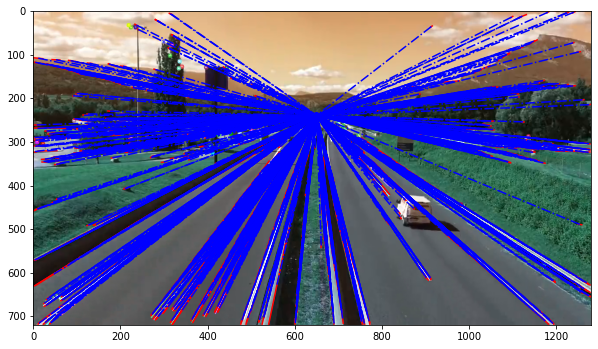

In [ ]:
# visualize model
vis_model(img,vp1)

In [ ]:
vp1

array([649.64632418, 239.19000177,   1.        ])

## Second vanishing point:

In [ ]:
def remove_inliers(model, edgelets, threshold_inlier=10):
    """Remove all inlier edglets of a given model.
    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.
    Returns
    -------
    edgelets_new: tuple of ndarrays
        All Edgelets except those which are inliers to model.
    """
    inliers = compute_votes(edgelets, model, 10) > 0
    locations, directions, strengths = edgelets
    locations = locations[~inliers]
    directions = directions[~inliers]
    strengths = strengths[~inliers]
    edgelets = (locations, directions, strengths)
    return edgelets

In [ ]:
# Remove edgelets from first vp
edgelets2 = remove_inliers(vp1, edgelets1, 10)

In [ ]:
vp2 = ransac_vanishing_point(edgelets2, num_ransac_iter=2000,
                             threshold_inlier=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


In [ ]:
vp2 = reestimate_model(vp2, edgelets2, threshold_reestimate=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


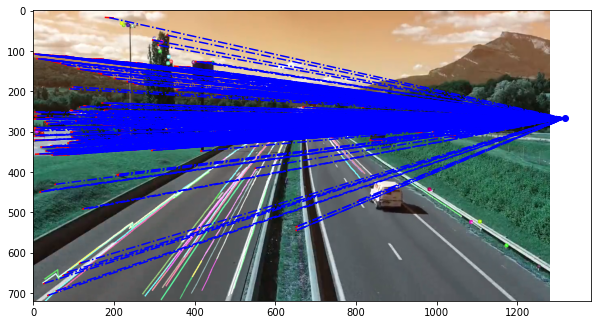

In [ ]:
vis_model(img, vp2)

In [ ]:
vp2

array([1.31702785e+03, 2.67056330e+02, 1.00000000e+00])